# Logistic Regression

## Loading train/test parquet from S3

In [1]:
import pandas as pd

path_train = "s3://crisk-nico-prod/curated/apps_merged_bureau_agg_1/"
path_test = "s3://crisk-nico-prod/curated/apps_merged_bureau_agg_test/"

df_train = pd.read_parquet(path_train, storage_options={"anon": False})
df_test = pd.read_parquet(path_test, storage_options={"anon": False})


## General information about data

* Glue ETL already standardized missingness & types
* Test set separation ensures unbiased evaluation
* dataset has 112 features and 1 binary label

In [2]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 113 entries, SK_ID_CURR to bucket_id
dtypes: category(1), float64(49), int64(51), object(12)
memory usage: 263.1+ MB


In [3]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 112 entries, SK_ID_CURR to bucket_id
dtypes: category(1), float64(49), int64(50), object(12)
memory usage: 41.3+ MB


## Splitting features and target

* `SK_ID_CURR` = identifier
* `bucket_id` = technical partition

In [4]:
Xtrain = df_train.drop(["SK_ID_CURR", "TARGET", "bucket_id"], axis=1)
ytrain = df_train["TARGET"]

Xtest = df_test.drop(["SK_ID_CURR", "bucket_id"], axis=1)

## Detect categorical and numerical features in training dataset

In [5]:
categorical_features = (Xtrain.select_dtypes(include='object').copy()).columns
numerical_features = (Xtrain.select_dtypes(include='number').copy()).columns

## Preprocessing Pipeline

* **Normalization** is required for logistic regression due to it is sentive to data magnitude and keep a stable training.
* **OneHotEncoder** converts categorical into numeric vectors, logistic regression just handle numerical features.
    * **drop='first':** avoids perfect multicollinearity, droping first columna (array of zeros).
    * **handle_unknown='ignore':** necessary for unseen categories in the test dataset.
* Create transformer `preprocess` for numerical and categorical features.

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

scalers = StandardScaler()
encoders = OneHotEncoder(drop='first', handle_unknown='ignore')

preprocess = ColumnTransformer(
    transformers=[
        ('num', scalers, numerical_features),
        ('cat', encoders, categorical_features)
    ]
)

## Choosing SGDClassifier (Log-Loss)

We have two ways to create the model, with SGD and implement the log-loss function or use the Closed-Form Logistic Regression. We decided to use SGD due to less computionally costs and is faster, however less exact reaching the optimum. Our dataset has round 300k rows and +100 features, so the Closed-Form Logistic Regression is not convenient. 

**Properties (Logistic)**

* Every point contributes to gradient.
* Produces probabilities naturally.

**Hyper-Params**

* **loss="log_loss"** is the Logistic Regression implementation.
* Applying penalty **L2** to penalize large weights to avoid overfitting, smoothness and helps generalization.
* **class_weight="balanced"** because balancing is required, with EDA analysis default represents only 8%, the dataset is highly imbalanced.
* **aplha** is the regularization ($1/C$).

In [7]:
from sklearn.linear_model import SGDClassifier

sgd_log = SGDClassifier(
    loss="log_loss",
    penalty="l2",
    alpha=0.1,
    class_weight="balanced",
)

Through Pipeline, it is possible to ensure same transformations applied at prediction stage.

In [8]:
from sklearn.pipeline import Pipeline

clf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', sgd_log)
])
clf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGIO...
                                                                handle_unknown='ignore'),
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object'))])),
                ('model',
                 SGDClassifier(alpha=0.1, class_weight='balanced',
                               loss='log_loss'))])

## Hyperparameter Tuning

Implemented Random Search due to:

* **Efficiency:** It searches over a random subset of hyperparameter combinations, which can be much faster than testing every possible combination (which is what GridSearchCV does).
* **Flexibility:** We can define ranges or distributions for the hyperparameters, and it will sample from those ranges.

We will tune the following hyperparameters for LogisticRegression:

* **alpha:** Regularization strength. Larger values mean more regularization (more penalty), while smaller values mean less regularization (less penalty).

We also implemented:
* we split training data into 3 folds through Cross-validation, so we train on 2th folds and validate on the 3rd.
* Evaluation metric **ROC** and **AUC**.


In [9]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
}

random_search = RandomizedSearchCV(
    clf,               
    param_distributions=param_dist,
    scoring='roc_auc',  
    cv=3,               
    verbose=3,          
    random_state=42,      
)

## Training the Model

We created the training and validation dataset. First of all, training the model and gather best hyper-parameters and AUC score for the training dataset.

In [10]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    Xtrain, ytrain, test_size=0.2, random_state=42, stratify=ytrain
)
random_search.fit(X_tr, y_tr)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best AUC score: {random_search.best_score_:.4f}")

c:\Python311\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END ................model__alpha=0.001;, score=0.741 total time=   8.6s
[CV 2/3] END ................model__alpha=0.001;, score=0.736 total time=   6.9s
[CV 3/3] END ................model__alpha=0.001;, score=0.741 total time=   7.3s
[CV 1/3] END .................model__alpha=0.01;, score=0.743 total time=   8.2s
[CV 2/3] END .................model__alpha=0.01;, score=0.738 total time=   7.0s
[CV 3/3] END .................model__alpha=0.01;, score=0.743 total time=   6.5s
[CV 1/3] END ..................model__alpha=0.1;, score=0.736 total time=   5.2s
[CV 2/3] END ..................model__alpha=0.1;, score=0.734 total time=   4.7s
[CV 3/3] END ..................model__alpha=0.1;, score=0.737 total time=   4.1s
[CV 1/3] END ....................model__alpha=1;, score=0.709 total time=   7.4s
[CV 2/3] END ....................model__alpha=1;, score=0.713 total time=   3.5s
[CV 3/3] END ....................model__alpha=1;,

This stage, we retrained the model but this time with best hyper-parameters. Therefore, make prediction with the validation dataset to analyze possible overfitting and model performance.

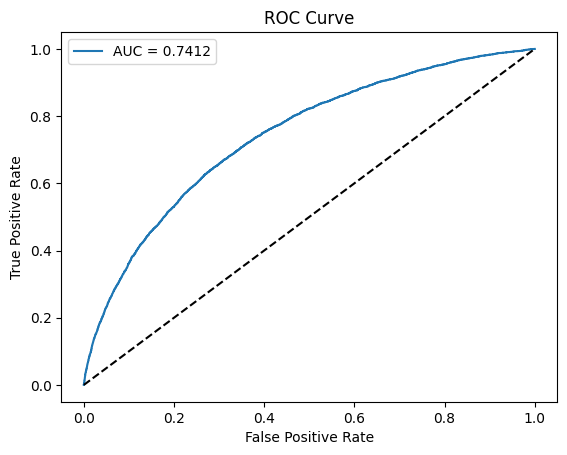

In [11]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

best_clf = random_search.best_estimator_

best_clf.fit(X_tr, y_tr)

y_val_proba = best_clf.predict_proba(X_val)[:, 1] 

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

There is not overfitting due to similar AUC values in training and validation datasets. They reach around **74%**. 

## Confusion Matrix & Metrics

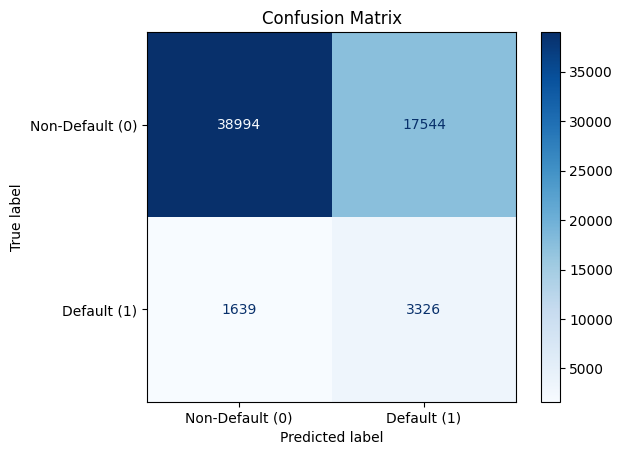

Best Threshold: 0.5028018680993759
G-Mean: 0.6797201881443664

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.67      0.26      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.90      0.69      0.76     61503



In [12]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    classification_report
)

gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
best_threshold = thresholds[ix]

y_pred_gmean = (y_val_proba >= best_threshold).astype(int)
confusion_matrix(y_val, y_pred_gmean)


cm = confusion_matrix(y_val, y_pred_gmean)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Non-Default (0)", "Default (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

print("Best Threshold:", best_threshold)
print("G-Mean:", gmeans[ix])

print("\nClassification Report:")
print(classification_report(y_val, y_pred_gmean))


### Analysis:
* **Recall**: The model catches around 66% of defaults, this represents a good value because, for this task, missing a default (False Negative) is worse than rejecting a good client (False Positive). Models aims is to reduce False Negative (high Recall).
* **Precision**: The model catches around 16% of precision. However this is expected due to imbalanced dataset, so many cases the precision for imbalanced tasks is not considered.
* **Threshold**: The best threshold found was 0.50, and G-mean gotten was 0.681.

## Feature Importance (Coefficients)

In linear models, feature importance is measured by:

* The absolute value of the coefficient

    * Large positive coefficient means that increases log-odds of default
    * Large negative coefficient means that decreases log-odds
    * Coefficients match the interpretation of odds ratios

In [13]:
transform_col = best_clf.named_steps['preprocess']

# Get the feature names after OneHotEncoding
encoded_columns = transform_col.get_feature_names_out()

coefficients = best_clf.named_steps['model'].coef_

coef_df = pd.DataFrame({
    'Feature': encoded_columns,
    'Coefficient': coefficients.flatten()
})

# Sort features by absolute value of coefficient to see most important features
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

coef_df.head(10)

,Feature,Coefficient,Abs_Coefficient
24,num__EXT_SOURCE_3,-0.425053,0.425053
23,num__EXT_SOURCE_2,-0.375219,0.375219
99,cat__CODE_GENDER_M,0.305206,0.305206
117,cat__NAME_EDUCATION_TYPE_Higher education,-0.272219,0.272219
101,cat__FLAG_OWN_CAR_Y,-0.188963,0.188963
121,cat__NAME_FAMILY_STATUS_Married,-0.172647,0.172647
67,num__ACTIVE_COUNT,0.155369,0.155369
113,cat__NAME_INCOME_TYPE_State servant,-0.148702,0.148702
30,num__FLAG_DOCUMENT_3,0.145726,0.145726
133,cat__OCCUPATION_TYPE_Core staff,-0.145353,0.145353


# Evaluate Test Dataset and Create Submission

Finally, we will re-train the model, but now with whole training dataset and predict `y_test` to create the submission.

In [14]:
X_train, X_test, y_train = Xtrain, Xtest, ytrain
best_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS',
       'REGIO...
                                                                handle_unknown='ignore'),
                                                  Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE'],
      dtype='object'))])),
                ('model',
                 SGDClassifier(alpha=0.01, class_weight='balanced',
                               loss='log_loss'))])

In [15]:
from sklearn.metrics import roc_auc_score

y_train_proba = best_clf.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_proba)

print(f"Train AUC: {train_auc:.4f}")

Train AUC: 0.7427


In [16]:
ytest = best_clf.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    'SK_ID_CURR': df_test['SK_ID_CURR'],
    'TARGET': ytest
})

s3_file_path = 's3://crisk-nico-prod/predictions/submissions/submission_log_loss_sgd.csv'

submission.to_csv(s3_file_path, index=False)

# Model Summary

**Model Type**

* Logistic Regression implemented via SGD.
* This choice provides scalability, interpretability, and aligns with PD modeling best practices.

**Performance**

* Train AUC around 74.27%
* Test AUC around 72.63% (Based on Kaggle score).
* No overfitting
* Good recall of defaults around 67%

**Interpretability**

* Coefficients show transparent relationships
* Confirms EDA risk drivers

**Strengths**

* Very fast training
* Works well with large, sparse OneHotEncodings
* Highly interpretable
* Well-calibrated probabilities
* Stable and low variance

**Weaknesses**

* Cannot model nonlinear interactions
* Dependent on good preprocessing